In [58]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
%matplotlib inline
sns.set()

In [59]:
data_sample = pd.read_csv('C:/ongo/DataSample__201709211530.csv').drop(['_id','owner','source','createdAt','updatedAt'],axis=1)
data_workout = pd.read_csv('C:/ongo/DataWorkoutRun__201709211532.csv')

In [60]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-heart-rate','health-sleep','health-weight']
type(x1)

pandas.core.series.Series

In [83]:

data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])

bmi = data_sample[data_sample['type'] == 'health-bmi']
bodyfat = data_sample[data_sample['type'] == 'health-body-fat']


bmi.index = bmi['startDate']
bodyfat.index = bodyfat['startDate']


bmi['value'] = pd.to_numeric(bmi['value'])
bmi = bmi.loc[:,'value']
#bmi = bmi.resample('W').mean()


bodyfat['value'] = pd.to_numeric(bodyfat['value'])
bodyfat = bodyfat.loc[:,'value']
#bodyfat = bodyfat.resample('W').mean()

bmi = bmi.to_frame('bmi')
bmi['bodyfat'] = bodyfat

bmi


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bmi,bodyfat
startDate,,
2014-08-27 21:41:23,26.738682,NaN
2014-08-28 06:24:53,26.586624,0.258699
2014-08-28 23:46:27,26.709702,0.249602
2014-08-29 06:45:05,26.557644,0.254801
2014-08-29 08:15:49,26.520008,0.250706
2014-08-29 21:40:15,26.665287,0.241563
2014-08-30 07:33:47,26.425158,0.250666
2014-08-31 03:03:05,27.069897,0.267832
2014-08-31 03:03:45,27.068392,0.270044


In [84]:
corr_linear = bmi['bmi'].corr(bmi['bodyfat'])
corr_linear

0.55495462844698362

In [85]:
corr_nonlinear = bmi['bmi'].corr(bmi['bodyfat'], method='spearman')
corr_nonlinear

0.78647864920220523

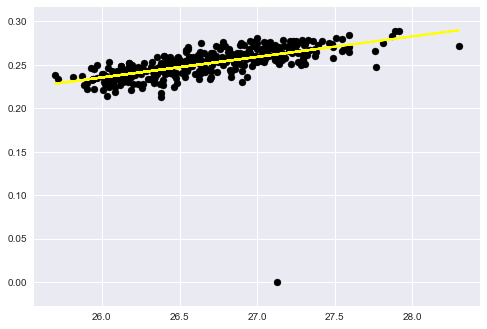

In [86]:
bmi = bmi.dropna()
x = bmi.bmi.values
y = bmi.bodyfat.values
x = x.reshape(len(x), 1)
y = y.reshape(len(x), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='yellow', linewidth=2)

In [82]:
regr.score(x, y)

0.39181675482551759

In [98]:
corr_info = stats.stats.pearsonr(x, y)
r = corr_info[0][0]
p = corr_info[1][0]
print ("The r value is {} and p is {}".format(r, p))

The r value is 0.554954628447 and p is 4.12439738829e-31


In [99]:
x = np.asarray([float(bmi['bmi'][i]) for i in range(len(bmi['bmi']))])
y = np.asarray([float(bmi['bodyfat'][i]) for i in range(len(bmi['bodyfat']))])

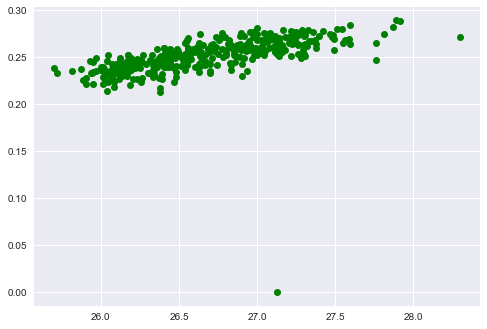

In [100]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#line = slope*x+intercept
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'go') #, x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)